In [1]:
using DataFrames
using DataFramesMeta
using Gadfly

Set up column names and empty data frame.

In [2]:
names_raw = ["Place","Guntime","Nettime","Pace","Name","Ag","S","Race#","City/state"]
names = [:place,:guntime,:nettime,:pace,:name,:age,:sex,:bib,:city,:state]
columns = Any[String[] for i in 1:length(names)]
df = DataFrame(columns,names)

,place,guntime,nettime,pace,name,age,sex,bib,city,state


Iterate through lines in text file, populating rows in the dataframe. Note that there are many lines in the text file that are not rows of data. All lines of data begin with a number, though we must ignore the lines that simply contain when the text file was generated.

In [3]:
filename = "cambridge-half-results.txt"
place_pos   = 1
guntime_pos = 2
nettime_pos = 3
pace_pos    = 4
name_pos    = 5
age_pos     = 6
sex_pos     = 7
bib_pos     = 8
city_pos    = 9
state_pos   = 10
nfields     = 10

10

Clean rows in which the name or city is initially parsed as separate fields because they are space-separated.

In [4]:
function clean_fields(raw_row)
    # Deal separately with "Unknown Runner"
    if raw_row[name_pos:name_pos+1] == ["Unknown", "Runner"]
        return clean_fields_unknown_runner(raw_row)
    end
    
    # Determine the index of the last field in the raw row that has part of the name.
    # We iterate through fields until a numeric value is reached (age).
    name_pos_raw_end = name_pos
    while !isnumber(raw_row[name_pos_raw_end+1])
        name_pos_raw_end += 1
    end
    
    # Determine the beginning and ending index in the raw row that together bound the city.
    city_pos_raw_begin = city_pos + (name_pos_raw_end - name_pos)
    city_pos_raw_end = length(raw_row) - 1

    # Actually fill in cleaned row, in 5 sections.
    clean_row = Vector{String}(length(names))
    clean_row[1:name_pos-1]          = raw_row[1:name_pos-1]
    clean_row[name_pos]              = join(raw_row[name_pos:name_pos_raw_end], " ")
    clean_row[name_pos+1:city_pos-1] = raw_row[name_pos_raw_end+1:city_pos_raw_begin-1]
    clean_row[city_pos]              = join(raw_row[city_pos_raw_begin:city_pos_raw_end], " ")  
    clean_row[city_pos+1:end]        = raw_row[city_pos_raw_end+1:end]
   
    return clean_row
end

function clean_fields_unknown_runner(raw_row)
    # Rows with unknown runners are missing fields age, sex, city, and state.
    clean_row = Vector{String}(length(names))
    clean_row[1:name_pos-1] = raw_row[1:name_pos-1]
    clean_row[name_pos]     = join(raw_row[name_pos:name_pos+1], " ")
    clean_row[age_pos]      = ""
    clean_row[sex_pos]      = ""
    clean_row[bib_pos]      = raw_row[end]
    clean_row[city_pos]     = ""
    clean_row[state_pos]    = ""
    
    return clean_row
end

clean_fields_unknown_runner (generic function with 1 method)

Iterate through the lines in the raw text file, skipping them or cleaning them and adding to DataFrame.

In [5]:
clean_row = open(filename, "r") do f
    for line in eachline(f)
        line = strip(line)
    
        # Ignore lines that are empty
        if isempty(line)
            continue
        end
        
        # Ignore lines that do not start with number
        if !startswith(line, [d for d in '0':'9'])
            continue
        end
        # Ignore lines that match a regex for the datetime the text file was generated. 
        # Informally, we match 'mm/dd/yyyy hh:mm?M'.
        r = r"^\d{1,2}/\d{1,2}/\d{4}\s*\d{1,2}:\d{2}(AM|PM)$"
        if ismatch(r, line)
            continue
        end
    
        # Can add this line to df, after we clean it -- the "name" and "city" fields can 
        # have spaces, thus we can merge runs of numeric fields together.
        raw_row = split(line)       
        clean_row = clean_fields(raw_row)
        
        push!(df, data(clean_row))
    end
end

In [6]:
# Clean all of the columns.
function str_to_minutes(str)
    if str[end] == '*'
        str = str[1:end-1]
    end
    d = split(str, ":")
    d = map(x -> parse(Int, x), d)
    if length(d) == 3
        return d[1]*60+d[2]+1.0*d[3]/60
    elseif length(d) == 2
        return d[1] + 1.0*d[2]/60
    else
        return NA
    end
end
function str_to_int(str)
    if str == ""
        return NA
    end
    
    try
        return parse(Int, str)
    catch e
        return NA
    end
end
for s in [:place, :age, :bib]
    df[s] = map(str_to_int, df[s])
end
for s in [:guntime, :nettime, :pace]
    df[s] = map(str_to_minutes, df[s])
end

In [7]:
# Drop any rows with missing data.
inds = Int[]
for i in 1:size(df,1)
    for j in 1:size(df,2)
        if isna(df[i,j])
            push!(inds, i)
            break
        end
    end
end
deleterows!(df, inds)

# Keep only rows in which sex is parsed correctly as "M" or "F".
df = @where(df, (:sex .== "M") | (:sex .== "F"))

,place,guntime,nettime,pace,name,age,sex,bib,city,state
1,1,68.46666666666667,68.45,5.233333333333333,Chris Allen,22,M,4214,Norfolk,MA
2,2,68.95,68.95,5.266666666666667,Andrea Sorgato,35,M,3468,Medford,MA
3,3,69.38333333333334,69.38333333333334,5.3,C Adam Pfander,22,M,3333,Brookline,MA
4,4,71.36666666666666,71.35,5.45,Stephen Polito,26,M,3469,Quincy,MA
5,5,72.43333333333334,72.41666666666667,5.533333333333333,Jack Stevenson,21,M,2613,New York,NY
6,6,73.3,73.3,5.6,Vasilis Kariolis,28,M,3467,Boston,MA
7,7,73.65,73.63333333333334,5.616666666666667,Michael Carlone,25,M,43,Somerville,MA
8,8,74.53333333333333,74.53333333333333,5.7,Samuel Goldberg,22,M,823,Cambridge,MA
9,9,74.58333333333333,74.56666666666666,5.7,Stephen Curley,24,M,2622,Norwood,MA
10,10,74.8,74.78333333333333,5.716666666666667,Lee Danforth,38,M,2716,Norwood,MA


In [8]:
# Some new features. Here, we define a version of `cut` that accepts labels.
function cut{S, T}(x::AbstractVector{S}, breaks::Vector{T}, labels::Vector{String})
    if !issorted(breaks)
        sort!(breaks)
    end
    min_x, max_x = minimum(x), maximum(x)
    if breaks[1] > min_x
        unshift!(breaks, min_x)
    end
    if breaks[end] < max_x
        push!(breaks, max_x)
    end
    refs = fill(zero(Int), length(x))
    for i in 1:length(x)
        if x[i] == min_x
            refs[i] = 1
        else
            refs[i] = searchsortedfirst(breaks, x[i]) - 1
        end
    end
    PooledDataArray(DataArrays.RefArray(refs), labels)
end

breaks_v1 = [20, 40, 60, 80]
labels_v1 = ["20 years or younger",
    "21 - 40 years",
    "41 - 60 years",
    "61 - 80 years",
    "Over 80 years"]
df[:age_cat_v1] = cut(df[:age], breaks_v1, labels_v1)

breaks_v2 = [20, 25, 30, 35, 40, 50, 65]
labels_v2 = ["20 years or younger",
    "21 - 25 years",
    "26 - 30 years",
    "31 - 35 years",
    "36 - 40 years",
    "41 - 50 years",
    "51 - 65 years",
    "Over 65 years"]
df[:age_cat_v2] = cut(df[:age], breaks_v2, labels_v2)

4535-element DataArrays.PooledDataArray{String,Int64,1}:
 "21 - 25 years"
 "31 - 35 years"
 "21 - 25 years"
 "26 - 30 years"
 "21 - 25 years"
 "26 - 30 years"
 "21 - 25 years"
 "21 - 25 years"
 "21 - 25 years"
 "36 - 40 years"
 "26 - 30 years"
 "26 - 30 years"
 "26 - 30 years"
 ⋮              
 "31 - 35 years"
 "36 - 40 years"
 "26 - 30 years"
 "41 - 50 years"
 "26 - 30 years"
 "41 - 50 years"
 "31 - 35 years"
 "26 - 30 years"
 "26 - 30 years"
 "26 - 30 years"
 "36 - 40 years"
 "31 - 35 years"

Produce summary statistics and some quick graphs.

In [9]:
head(df)

,place,guntime,nettime,pace,name,age,sex,bib,city,state,age_cat_v1,age_cat_v2
1,1,68.46666666666667,68.45,5.233333333333333,Chris Allen,22,M,4214,Norfolk,MA,21 - 40 years,21 - 25 years
2,2,68.95,68.95,5.266666666666667,Andrea Sorgato,35,M,3468,Medford,MA,21 - 40 years,31 - 35 years
3,3,69.38333333333334,69.38333333333334,5.3,C Adam Pfander,22,M,3333,Brookline,MA,21 - 40 years,21 - 25 years
4,4,71.36666666666666,71.35,5.45,Stephen Polito,26,M,3469,Quincy,MA,21 - 40 years,26 - 30 years
5,5,72.43333333333334,72.41666666666667,5.533333333333333,Jack Stevenson,21,M,2613,New York,NY,21 - 40 years,21 - 25 years
6,6,73.3,73.3,5.6,Vasilis Kariolis,28,M,3467,Boston,MA,21 - 40 years,26 - 30 years


In [10]:
describe(df)

place
Min      1.0
1st Qu.  1142.5
Median   2280.0
Mean     2280.54796030871
3rd Qu.  3420.5
Max      4560.0
NAs      0
NA%      0.0%

guntime
Min      68.46666666666667
1st Qu.  109.09166666666667
Median   122.76666666666667
Mean     124.23708930540242
3rd Qu.  138.1
Max      189.96666666666667
NAs      0
NA%      0.0%

nettime
Min      68.45
1st Qu.  107.05833333333334
Median   119.21666666666667
Mean     120.86838662256523
3rd Qu.  133.41666666666666
Max      189.5
NAs      0
NA%      0.0%

pace
Min      5.233333333333333
1st Qu.  8.166666666666666
Median   9.1
Mean     9.22752296949651
3rd Qu.  10.183333333333334
Max      14.466666666666667
NAs      0
NA%      0.0%

name
Length  4535
Type    String
NAs     0
NA%     0.0%
Unique  4525

age
Length  4535
Type    Any
NAs     0
NA%     0.0%
Unique  56

sex
Length  4535
Type    String
NAs     0
NA%     0.0%
Unique  2

bib
Length  4535
Type    Any
NAs     0
NA%     0.0%
Unique  4535

city
Length  4535
Type    String
NAs     0
NA%     0.0%

In [11]:
# Sorted by place (and thus pace).
fastest_time = floor(df[:pace][1])
slowest_time = ceil(df[:pace][end])
ticks = collect(fastest_time:1:slowest_time)
nothing

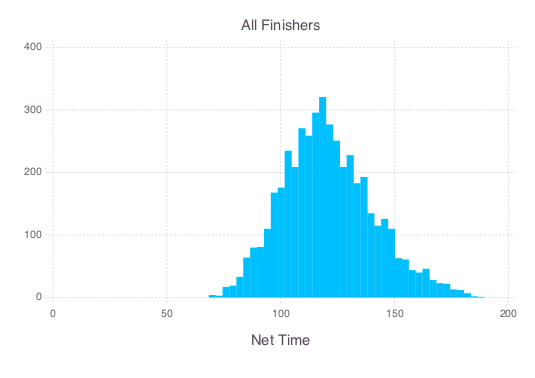

In [12]:
# Histogram of nettime of all runners.
p = plot(df, x=:nettime, Geom.histogram(bincount = 40),
    Guide.xlabel("Net Time"),
    Guide.title("All Finishers"))

draw(SVGJS("nettime_hist.js.svg", 6inch, 4inch), p)

p

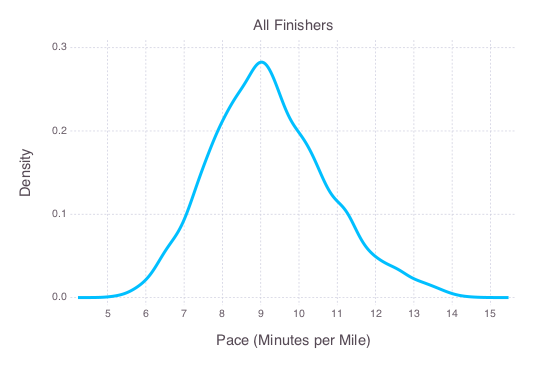

In [13]:
# Density estimate of nettime of all runners.
p = plot(df, x=:pace, Geom.density,
    Theme(line_width = 3px),
    Guide.title("All Finishers"),
    Guide.ylabel("Density"),
    Guide.xlabel("Pace (Minutes per Mile)"),
    Guide.xticks(ticks=ticks))

draw(SVGJS("density_all.js.svg", 6inch, 4inch), p)

p

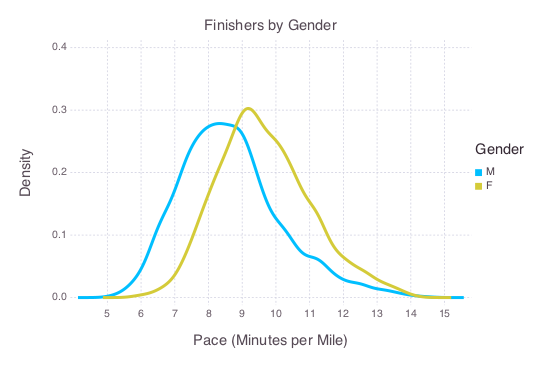

In [14]:
# Density estimate of nettime of runners, grouped by gender
p = plot(df, x=:pace, color = :sex, 
    Geom.density, Theme(line_width = 3px),
    Guide.xlabel("Pace (Minutes per Mile)"),
    Guide.ylabel("Density"),
    Guide.title("Finishers by Gender"),
    Guide.colorkey("Gender"),
    Guide.xticks(ticks=ticks))

draw(SVGJS("density_gender.js.svg", 6inch, 4inch), p)

p

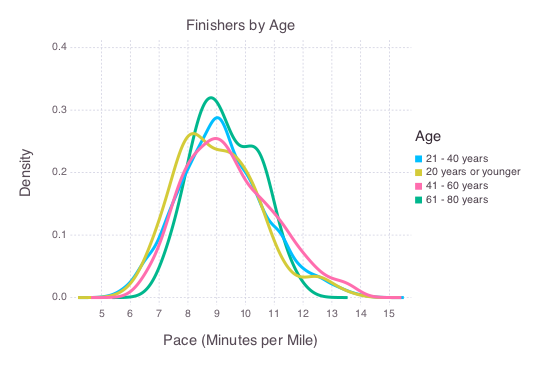

In [18]:
# Density estimate of nettime of runners, grouped by age bracket (bracket categories #2)
p = plot(df, x=:pace, color = :age_cat_v1,
    Geom.density, Theme(line_width = 3px),
    Guide.xlabel("Pace (Minutes per Mile)"),
    Guide.ylabel("Density"),
    Guide.title("Finishers by Age"),
    Guide.colorkey("Age"),
    Guide.xticks(ticks=ticks))

draw(SVGJS("density_age_v1.js.svg", 6inch, 4inch), p)

p

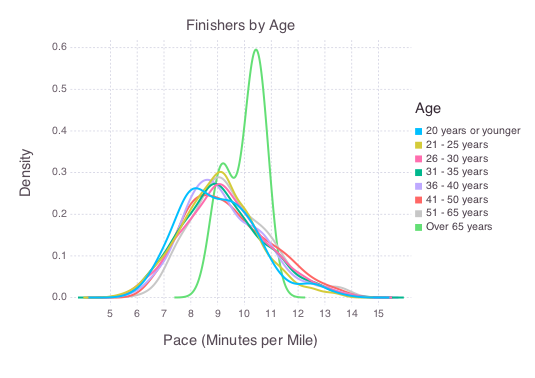

In [16]:
# Density estimate of nettime of runners, grouped by age bracket (bracket categories #2).
# We manually generate a layer for each category and create a manual colorkey because Gadfly's
# behavior when we pass the entire DataFrame and provide color = :age_cat_v2 is to
# place "20 years or younger" out of order in the colorkey.
a = Scale.color_discrete_hue()
mycolors = a.f(length(labels_v2))
layers = [layer(@where(df, :age_cat_v2 .== labels_v2[i]), x=:pace, 
    Geom.density, Theme(line_width = 2px, default_color=mycolors[i]))
    for i in 1:length(labels_v2)]
p = plot(layers...,
    Guide.xlabel("Pace (Minutes per Mile)"),
    Guide.ylabel("Density"),
    Guide.title("Finishers by Age"),
    Guide.xticks(ticks=ticks),
    Guide.manual_color_key("Age", labels_v2, mycolors))

draw(SVGJS("density_age_v2.js.svg", 6inch, 4inch), p)

p

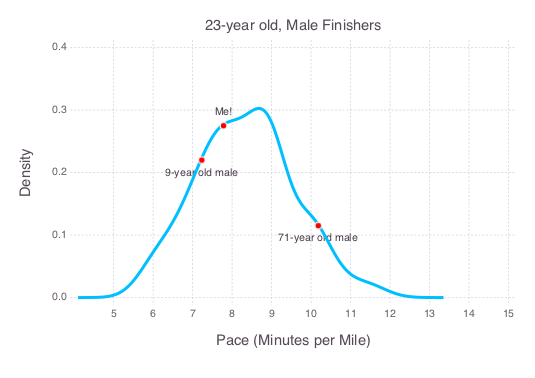

In [17]:
# Compare my time to others in my demographic -- and show the youngest and oldest runners.
df_23m = @where(df, :age .== 23, :sex .== "M")
l = layer(df_23m, x=:pace, Geom.density,
    Theme(line_width = 3px))

df_youngest = @where(df, :age .== minimum(:age))
df_youngest[:y] = [0.22]
age_string = string(df_youngest[:age][1])*"-year old"
sex_string = df_youngest[:sex][1] == "M" ? "male" : "female"
df_youngest[:label] = "$(age_string) $(sex_string)"

df_oldest = @where(df, :age .== maximum(:age))
df_oldest[:y] = [0.115]
age_string = string(df_oldest[:age][1])*"-year old"
sex_string = df_oldest[:sex][1] == "M" ? "male" : "female"
df_oldest[:label] = "$(age_string) $(sex_string)"

df_examples = vcat(df_youngest, df_oldest)

df_micah = @where(df, :name .== "Micah Smith")
df_micah[:y] = [0.275]
df_micah[:label] = "Me!"


l1 = layer(df_examples, x=:pace, y=:y, label = :label, Geom.point, Geom.label(position=:below),
    Theme(default_color=colorant"red"))
l2 = layer(df_micah, x=:pace, y=:y, label = :label, Geom.point, Geom.label(position=:above),
    Theme(default_color=colorant"red"))

p = plot(l1, l2, l,
Guide.ylabel(""),
Guide.title("23-year old, Male Finishers"),
Guide.xticks(ticks=ticks),
Guide.xlabel("Pace (Minutes per Mile)"),
Guide.ylabel("Density"),
Scale.x_continuous(minvalue = fastest_time, maxvalue = slowest_time))

draw(SVGJS("density_micah.js.svg", 6inch, 4inch), p)

p